In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from collections import Counter
from datetime import datetime, timedelta
from sklearn import metrics
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn import ensemble
import sklearn.metrics
import time
from datetime import datetime

%matplotlib inline                                
#no need to do plt.show()

In [2]:
train = pd.read_csv('./train.csv',parse_dates=['date'])
test = pd.read_csv('./test.csv',parse_dates=['date'],index_col = 0)
print( ' train shape:{}, columns:{} '.format(train.shape,train.columns))
print( ' test shape:{}, columns:{}'.format(test.shape,test.columns))

print(train['date'].head())
print(train.columns)
train.head()

 train shape:(14006, 3), columns:Index(['id', 'date', 'speed'], dtype='object') 
 test shape:(3504, 1), columns:Index(['date'], dtype='object')
0   2017-01-01 00:00:00
1   2017-01-01 01:00:00
2   2017-01-01 02:00:00
3   2017-01-01 03:00:00
4   2017-01-01 04:00:00
Name: date, dtype: datetime64[ns]
Index(['id', 'date', 'speed'], dtype='object')


,id,date,speed
0,0,2017-01-01 00:00:00,43.002930
1,1,2017-01-01 01:00:00,46.118696
2,2,2017-01-01 02:00:00,44.294158
3,3,2017-01-01 03:00:00,41.067468
4,4,2017-01-01 04:00:00,46.448653


In [3]:
###处理特征
#计划   season4个特征+周几+年+月+日+时+是否节假日

#周几+年+月+日+时
for df in (train,test): 
    df['year']  = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day']   = df['date'].dt.day
    df['hr']    = df['date'].dt.hour
    df["weekdayth"] = df['date'].dt.weekday                                  #周几
    df["weekofyear"] = df['date'].dt.isocalendar().week.astype("int")
    df["dayofyear"] = df['date'].dt.dayofyear
    
    
for df in (train,test):
    df['y/n-weekday'] = np.nan 
    
    df.loc[(df.weekdayth==5),'y/n-weekday']=1  #周六为1
    df.loc[(df.weekdayth<=4),'y/n-weekday']=0  #工作日为0
    df.loc[(df.weekdayth==6),'y/n-weekday']=2  #周天为2

    
#时 转 白天黑夜早晚高峰      
for df in (train,test):
    df['hr-categori'] = np.nan #创建一个空字段，选择一个内容进行占位，不影响后面数据的插入
    df.loc[(df.weekdayth <= 4)&(df.weekdayth >= 0)&(df.hr <= 9)&(df.hr >= 7), 'hr-categori'] = 3   #工作日的早高峰7-9点
    df.loc[(df.weekdayth <= 4)&(df.weekdayth >= 0)&(df.hr <= 19)&(df.hr >= 17), 'hr-categori'] = 3  #工作日的晚高峰17-19点
    
    df.loc[(df.weekdayth <= 4)&(df.weekdayth >= 0)&(df.hr >= 0)&(df.hr < 7), 'hr-categori'] = 0
    df.loc[(df.weekdayth <= 4)&(df.weekdayth >= 0)&(df.hr > 9)&(df.hr < 17), 'hr-categori'] = 1
    df.loc[(df.weekdayth <= 4)&(df.weekdayth >= 0)&(df.hr >19)&(df.hr <= 24), 'hr-categori'] = 2

    df.loc[(df.weekdayth >= 5)&(df.hr < 19)&(df.hr > 7), 'hr-categori'] = 4                      #周末的白天
    df.loc[(df.weekdayth >= 5)&(df.hr <= 7)|(df.hr >= 19), 'hr-categori'] = 5                    #周末的晚上

    
#加香港2017 2018节假日       ：date speed year month day hr weekday weekofyear season dayofyear hr-categori y/n-holiday
public_vacation_list = [
    '20180101', '20180216','20180217','20180219','20180330','20180331','20180402','20180405',
    '20180501','20180522','20180618','20180702','20180925','20181001','20181017','20181225','20181226',
    '20170102','20170128','20170130','20170131','20170404','20170414','20170415','20170417','20170501',
    '20170503','20170530','20170701','20171002','20171005','20171028','20171225','20171226'
] 
for df in (train,test):
    df['only-ymd'] = df['date'].apply(lambda x: x.strftime('%Y%m%d'))
    df['y/n-holiday'] = df['only-ymd'].apply(lambda x: 1 if x in public_vacation_list else 0)

#季节
season_dict = {
    3: 0, 4: 0, 5: 0,
    6: 1, 7: 1, 8: 1,
    9: 2, 10: 2, 11: 2,
    12: 3, 1: 3, 2: 3,}

for df in (train,test):
    df['season']=df['month'].map(season_dict)

#周123很像-0，周四五-1，周天-2，周天-3
weekday_dict = {
    0: 0, 1: 0, 2: 0,
    3: 1, 4: 1,
    5: 2, 
    6: 3,}

for df in (train,test):
    df['weekdaythclass']=df['weekdayth'].map(weekday_dict)

    
    
    
df_train = train.drop(columns= ['only-ymd','date','id'], axis= 1).copy()
df_test = test.drop(columns= ['only-ymd','date'], axis= 1).copy()


In [20]:
df_train.corr()['speed']    #查看相关性

speed             1.000000
year              0.015102
month            -0.028827
day              -0.019485
hr               -0.390044
weekdayth         0.115887
weekofyear       -0.026907
dayofyear        -0.030255
y/n-weekday       0.171853
hr-categori      -0.017517
y/n-holiday       0.055386
season            0.014134
weekdaythclass    0.151015
Name: speed, dtype: float64

In [17]:
####不需要编码了
from sklearn.model_selection import train_test_split
#留出法划分数据,就按照经典的37分
Train, Valid = train_test_split(df_train, test_size = 0.2)  


X_train = Train.drop(['speed'], axis=1)     #提取训练数据自变量

Y_train = Train["speed"]                    #提取训练数据因变量

X_valid = Valid.drop(['speed'], axis=1)       #提取测试数据自变量

Y_valid = Valid["speed"]                      #提取测试数据因变量


Y_valid = Y_valid.reset_index().drop('index',axis = 1)
Y_train = Y_train.reset_index().drop('index',axis = 1)
#重新进行索引顺序



#加载模型，放入相关数据
dtrain = xgb.DMatrix(X_train, label=Y_train)    #放入训练数据
dvalid = xgb.DMatrix(X_valid, label=Y_valid)      #放入测试拟合与否的数据

dtest = xgb.DMatrix(df_test)                #放入最终的需要提交的检测数据

In [18]:
xgb_pars = {
    'nthread':            4,  
    'objective':          'reg:squarederror',
    'learning_rate':      0.02,
    'min_child_weight':   1,   
    'max_depth':          10,  
    'subsample':          0.87,
    'colsample_bytree':   1,
    'colsample_bylevel':  0.7,
    'verbosity':             0,
    'reg_alpha':          0.1,
    'gamma':              0,
    #'reg_lambda':         0.4,
}

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

model = xgb.train(xgb_pars, dtrain, 1500, watchlist, early_stopping_rounds=10,
      maximize=False, verbose_eval=1)

print('Modeling RMSLE %.5f' % model.best_score)



[0]	train-rmse:34.35290	valid-rmse:34.26720
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[1]	train-rmse:33.68631	valid-rmse:33.59851
[2]	train-rmse:33.03311	valid-rmse:32.94450
[3]	train-rmse:32.39314	valid-rmse:32.30435
[4]	train-rmse:31.76634	valid-rmse:31.67549
[5]	train-rmse:31.15230	valid-rmse:31.05958
[6]	train-rmse:30.55112	valid-rmse:30.45645
[7]	train-rmse:29.96200	valid-rmse:29.86581
[8]	train-rmse:29.38555	valid-rmse:29.28771
[9]	train-rmse:28.82139	valid-rmse:28.72193
[10]	train-rmse:28.26750	valid-rmse:28.16674
[11]	train-rmse:27.72440	valid-rmse:27.62385
[12]	train-rmse:27.19306	valid-rmse:27.09205
[13]	train-rmse:26.67227	valid-rmse:26.57079
[14]	train-rmse:26.16287	valid-rmse:26.06072
[15]	train-rmse:25.66427	valid-rmse:25.56169
[16]	train-rmse:25.17558	valid-rmse:25.07303
[17]	train-rmse:24.69684	valid-rmse:24.59438
[18]	train-rmse:24.22939	valid-rmse:24.12786
[19]	train

[183]	train-rmse:3.78123	valid-rmse:4.55137
[184]	train-rmse:3.76697	valid-rmse:4.54438
[185]	train-rmse:3.75464	valid-rmse:4.53642
[186]	train-rmse:3.74651	valid-rmse:4.53179
[187]	train-rmse:3.73324	valid-rmse:4.52635
[188]	train-rmse:3.71940	valid-rmse:4.51745
[189]	train-rmse:3.70910	valid-rmse:4.51200
[190]	train-rmse:3.70062	valid-rmse:4.50867
[191]	train-rmse:3.68647	valid-rmse:4.49905
[192]	train-rmse:3.67556	valid-rmse:4.49288
[193]	train-rmse:3.66630	valid-rmse:4.48766
[194]	train-rmse:3.66111	valid-rmse:4.48508
[195]	train-rmse:3.65049	valid-rmse:4.48176
[196]	train-rmse:3.64107	valid-rmse:4.47675
[197]	train-rmse:3.62966	valid-rmse:4.47068
[198]	train-rmse:3.62015	valid-rmse:4.46541
[199]	train-rmse:3.61378	valid-rmse:4.46191
[200]	train-rmse:3.60566	valid-rmse:4.45921
[201]	train-rmse:3.59417	valid-rmse:4.45105
[202]	train-rmse:3.58650	valid-rmse:4.44727
[203]	train-rmse:3.57339	valid-rmse:4.44037
[204]	train-rmse:3.56638	valid-rmse:4.43688
[205]	train-rmse:3.55833	valid-r

[370]	train-rmse:2.54040	valid-rmse:3.99126
[371]	train-rmse:2.53520	valid-rmse:3.99019
[372]	train-rmse:2.52958	valid-rmse:3.98914
[373]	train-rmse:2.52586	valid-rmse:3.98763
[374]	train-rmse:2.52140	valid-rmse:3.98586
[375]	train-rmse:2.51598	valid-rmse:3.98335
[376]	train-rmse:2.51071	valid-rmse:3.98263
[377]	train-rmse:2.50568	valid-rmse:3.98058
[378]	train-rmse:2.50075	valid-rmse:3.97869
[379]	train-rmse:2.49698	valid-rmse:3.97846
[380]	train-rmse:2.49243	valid-rmse:3.97655
[381]	train-rmse:2.48810	valid-rmse:3.97443
[382]	train-rmse:2.48357	valid-rmse:3.97327
[383]	train-rmse:2.47843	valid-rmse:3.97141
[384]	train-rmse:2.47523	valid-rmse:3.96982
[385]	train-rmse:2.46983	valid-rmse:3.96696
[386]	train-rmse:2.46528	valid-rmse:3.96512
[387]	train-rmse:2.46368	valid-rmse:3.96440
[388]	train-rmse:2.46167	valid-rmse:3.96406
[389]	train-rmse:2.46038	valid-rmse:3.96306
[390]	train-rmse:2.45792	valid-rmse:3.96190
[391]	train-rmse:2.45261	valid-rmse:3.96034
[392]	train-rmse:2.44673	valid-r

[557]	train-rmse:1.96188	valid-rmse:3.83270
[558]	train-rmse:1.95865	valid-rmse:3.83303
[559]	train-rmse:1.95705	valid-rmse:3.83238
[560]	train-rmse:1.95634	valid-rmse:3.83208
[561]	train-rmse:1.95402	valid-rmse:3.83180
[562]	train-rmse:1.95155	valid-rmse:3.83080
[563]	train-rmse:1.94960	valid-rmse:3.82986
[564]	train-rmse:1.94861	valid-rmse:3.82984
[565]	train-rmse:1.94532	valid-rmse:3.82920
[566]	train-rmse:1.94428	valid-rmse:3.82895
[567]	train-rmse:1.94130	valid-rmse:3.82823
[568]	train-rmse:1.93919	valid-rmse:3.82720
[569]	train-rmse:1.93799	valid-rmse:3.82725
[570]	train-rmse:1.93583	valid-rmse:3.82669
[571]	train-rmse:1.93435	valid-rmse:3.82641
[572]	train-rmse:1.93196	valid-rmse:3.82578
[573]	train-rmse:1.93056	valid-rmse:3.82551
[574]	train-rmse:1.92916	valid-rmse:3.82515
[575]	train-rmse:1.92810	valid-rmse:3.82493
[576]	train-rmse:1.92477	valid-rmse:3.82463
[577]	train-rmse:1.92177	valid-rmse:3.82396
[578]	train-rmse:1.91863	valid-rmse:3.82341
[579]	train-rmse:1.91728	valid-r

[744]	train-rmse:1.58401	valid-rmse:3.77527
[745]	train-rmse:1.58242	valid-rmse:3.77506
[746]	train-rmse:1.58105	valid-rmse:3.77491
[747]	train-rmse:1.57943	valid-rmse:3.77465
[748]	train-rmse:1.57804	valid-rmse:3.77459
[749]	train-rmse:1.57567	valid-rmse:3.77420
[750]	train-rmse:1.57385	valid-rmse:3.77445
[751]	train-rmse:1.57193	valid-rmse:3.77420
[752]	train-rmse:1.57131	valid-rmse:3.77406
[753]	train-rmse:1.56911	valid-rmse:3.77382
[754]	train-rmse:1.56708	valid-rmse:3.77403
[755]	train-rmse:1.56418	valid-rmse:3.77388
[756]	train-rmse:1.56297	valid-rmse:3.77364
[757]	train-rmse:1.56182	valid-rmse:3.77371
[758]	train-rmse:1.56034	valid-rmse:3.77353
[759]	train-rmse:1.55860	valid-rmse:3.77325
[760]	train-rmse:1.55644	valid-rmse:3.77275
[761]	train-rmse:1.55507	valid-rmse:3.77288
[762]	train-rmse:1.55300	valid-rmse:3.77282
[763]	train-rmse:1.55183	valid-rmse:3.77264
[764]	train-rmse:1.55008	valid-rmse:3.77217
[765]	train-rmse:1.54911	valid-rmse:3.77218
[766]	train-rmse:1.54686	valid-r

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

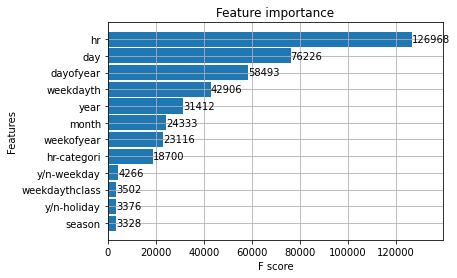

In [15]:
fscores = model.get_fscore()
#top_50_list = sorted(fscores, key=fscores.get, reverse=True)[:50]
#比如获得前50个特征的排序

xgb.plot_importance(model, max_num_features=20, height=0.9)
#前20特征值绘制条状图

In [16]:
pred = model.predict(dtest)
result = pd.DataFrame({"id":range(3504), "speed":pred})
result.to_csv("submission14.csv", index=False)